[과제]  
고객만족 예측 모델 생성, 평가(AUC) 및 중요 변수 시각화를 수행 하세요
- XGBoost
- LightGBM

In [8]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib

cust_df = pd.read_csv("dataset/santander/train_santander.csv",encoding='latin-1')
print('dataset shape:', cust_df.shape)
cust_df.head(5)

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


In [5]:
cust_df.TARGET.value_counts()

0    73012
1     3008
Name: TARGET, dtype: int64

In [2]:
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt = cust_df[cust_df['TARGET'] == 1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print('unsatisfied 비율은 {0:.2f}'.format((unsatisfied_cnt / total_cnt)))

0    73012
1     3008
Name: TARGET, dtype: int64
unsatisfied 비율은 0.04


In [11]:
cust_df.var3.value_counts()
# cust_df.describe()

 2         74165
 8           138
-999999      116
 9           110
 3           108
           ...  
 177           1
 87            1
 151           1
 215           1
 191           1
Name: var3, Length: 208, dtype: int64

In [12]:
# var3 피처 값 대체 및 ID 피처 드롭
cust_df['var3'].replace(-999999,2, inplace=True)
cust_df.drop('ID',axis=1 , inplace=True)

# 피처 세트와 레이블 세트분리. 레이블 컬럼은 DataFrame의 맨 마지막에 위치해 컬럼 위치 -1로 분리
X_features = cust_df.iloc[:, :-1]
y_labels = cust_df.iloc[:, -1]
print('피처 데이터 shape:{0}'.format(X_features.shape))

피처 데이터 shape:(76020, 369)


In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels,
                                                    test_size=0.2, random_state=0) # stratify=y_labels
train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(X_train.shape , X_test.shape))

print(' 학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 Shape:(60816, 369), 테스트 세트 Shape:(15204, 369)
 학습 세트 레이블 값 분포 비율
0    0.960964
1    0.039036
Name: TARGET, dtype: float64

 테스트 세트 레이블 값 분포 비율
0    0.9583
1    0.0417
Name: TARGET, dtype: float64


In [15]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

xgb_clf = XGBClassifier(n_estimators=500, random_state=156)
xgb_clf.fit(X_train, y_train, early_stopping_rounds=100,
            eval_metric="auc", eval_set=[(X_train, y_train), (X_test, y_test)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1],average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.799928	validation_1-auc:0.803548
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.802222	validation_1-auc:0.805222
[2]	validation_0-auc:0.80819	validation_1-auc:0.813162
[3]	validation_0-auc:0.8127	validation_1-auc:0.813243
[4]	validation_0-auc:0.81648	validation_1-auc:0.816979
[5]	validation_0-auc:0.816018	validation_1-auc:0.816629
[6]	validation_0-auc:0.816474	validation_1-auc:0.817776
[7]	validation_0-auc:0.818148	validation_1-auc:0.818464
[8]	validation_0-auc:0.81806	validation_1-auc:0.818295
[9]	validation_0-auc:0.817039	validation_1-auc:0.818087
[10]	validation_0-auc:0.818318	validation_1-auc:0.818749
[11]	validation_0-auc:0.818711	validation_1-auc:0.818521
[12]	validation_0-auc:0.818673	validation_1-auc:0.818516
[13]	validation_0-auc:0.819156	validation_1-auc:0.818998
[14]	validation_0-auc:0.819847	validation_1-auc:0.81999
[15

[142]	validation_0-auc:0.861553	validation_1-auc:0.841335
[143]	validation_0-auc:0.861682	validation_1-auc:0.841346
[144]	validation_0-auc:0.86169	validation_1-auc:0.841403
[145]	validation_0-auc:0.861852	validation_1-auc:0.841299
[146]	validation_0-auc:0.861898	validation_1-auc:0.841301
[147]	validation_0-auc:0.861998	validation_1-auc:0.841289
[148]	validation_0-auc:0.862068	validation_1-auc:0.84135
[149]	validation_0-auc:0.862132	validation_1-auc:0.841444
[150]	validation_0-auc:0.862236	validation_1-auc:0.841409
[151]	validation_0-auc:0.862314	validation_1-auc:0.841459
[152]	validation_0-auc:0.862584	validation_1-auc:0.841456
[153]	validation_0-auc:0.862843	validation_1-auc:0.841483
[154]	validation_0-auc:0.863033	validation_1-auc:0.841493
[155]	validation_0-auc:0.863132	validation_1-auc:0.841534
[156]	validation_0-auc:0.863423	validation_1-auc:0.841728
[157]	validation_0-auc:0.863578	validation_1-auc:0.841712
[158]	validation_0-auc:0.863872	validation_1-auc:0.841677
[159]	validation

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

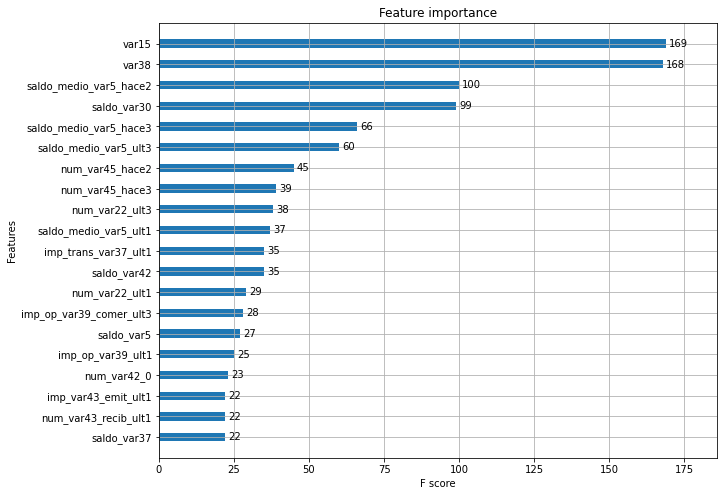

In [16]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1,figsize=(10,8))
plot_importance(xgb_clf, ax=ax , max_num_features=20,height=0.4)

LightGBM

In [18]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=500)

evals = [(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="auc", eval_set=evals,
                verbose=True)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1],average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's auc: 0.817384	valid_0's binary_logloss: 0.165046
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.818903	valid_0's binary_logloss: 0.160006
[3]	valid_0's auc: 0.827707	valid_0's binary_logloss: 0.156323
[4]	valid_0's auc: 0.832155	valid_0's binary_logloss: 0.153463
[5]	valid_0's auc: 0.834677	valid_0's binary_logloss: 0.151256
[6]	valid_0's auc: 0.834093	valid_0's binary_logloss: 0.149427
[7]	valid_0's auc: 0.837046	valid_0's binary_logloss: 0.147961
[8]	valid_0's auc: 0.837838	valid_0's binary_logloss: 0.146591
[9]	valid_0's auc: 0.839435	valid_0's binary_logloss: 0.145455
[10]	valid_0's auc: 0.83973	valid_0's binary_logloss: 0.144486
[11]	valid_0's auc: 0.839799	valid_0's binary_logloss: 0.143769
[12]	valid_0's auc: 0.840034	valid_0's binary_logloss: 0.143146
[13]	valid_0's auc: 0.840271	valid_0's binary_logloss: 0.142533
[14]	valid_0's auc: 0.840342	valid_0's binary_logloss: 0.142036
[15]	valid_0's auc: 0.840928	valid_0's binary_loglos

In [21]:
from sklearn.model_selection import GridSearchCV

LGBM_clf = LGBMClassifier(n_estimators=200)

params = {'num_leaves': [32,64],
         'max_depth':[128,160],
         'min_child_samples':[60,100],
         'subsample':[0.8,1]}
gridcv = GridSearchCV(LGBM_clf,param_grid=params)
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric='auc', \
                      eval_set=[(X_train,y_train),(X_test,y_test)])
print('GCV 최적 파라미터:', gridcv.best_params_)
lgbm_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:,1], average='macro')
print('AUC:{0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's auc: 0.823664	valid_0's binary_logloss: 0.156198	valid_1's auc: 0.821078	valid_1's binary_logloss: 0.16488
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.82966	valid_0's binary_logloss: 0.150925	valid_1's auc: 0.826326	valid_1's binary_logloss: 0.159774
[3]	valid_0's auc: 0.834498	valid_0's binary_logloss: 0.147158	valid_1's auc: 0.826852	valid_1's binary_logloss: 0.156113
[4]	valid_0's auc: 0.83904	valid_0's binary_logloss: 0.144173	valid_1's auc: 0.831417	valid_1's binary_logloss: 0.153186
[5]	valid_0's auc: 0.841964	valid_0's binary_logloss: 0.141745	valid_1's auc: 0.834593	valid_1's binary_logloss: 0.150797
[6]	valid_0's auc: 0.845253	valid_0's binary_logloss: 0.139712	valid_1's auc: 0.836659	valid_1's binary_logloss: 0.149062
[7]	valid_0's auc: 0.846545	valid_0's binary_logloss: 0.138053	valid_1's auc: 0.836148	valid_1's binary_logloss: 0.147537
[8]	valid_0's auc: 0.848885	valid_0's binary_logloss: 0.1366	valid_1's auc: 0.838153	val

[23]	valid_0's auc: 0.869182	valid_0's binary_logloss: 0.126269	valid_1's auc: 0.836587	valid_1's binary_logloss: 0.140588
[24]	valid_0's auc: 0.869979	valid_0's binary_logloss: 0.125886	valid_1's auc: 0.836766	valid_1's binary_logloss: 0.140496
[25]	valid_0's auc: 0.870956	valid_0's binary_logloss: 0.125545	valid_1's auc: 0.837001	valid_1's binary_logloss: 0.140322
[26]	valid_0's auc: 0.872886	valid_0's binary_logloss: 0.125108	valid_1's auc: 0.836911	valid_1's binary_logloss: 0.140274
[27]	valid_0's auc: 0.873971	valid_0's binary_logloss: 0.124767	valid_1's auc: 0.836733	valid_1's binary_logloss: 0.140247
[28]	valid_0's auc: 0.875129	valid_0's binary_logloss: 0.124434	valid_1's auc: 0.837012	valid_1's binary_logloss: 0.140143
[29]	valid_0's auc: 0.875873	valid_0's binary_logloss: 0.12414	valid_1's auc: 0.836866	valid_1's binary_logloss: 0.140163
[30]	valid_0's auc: 0.876465	valid_0's binary_logloss: 0.123865	valid_1's auc: 0.836337	valid_1's binary_logloss: 0.140195
[31]	valid_0's au

[26]	valid_0's auc: 0.872679	valid_0's binary_logloss: 0.124953	valid_1's auc: 0.838853	valid_1's binary_logloss: 0.139811
[27]	valid_0's auc: 0.873565	valid_0's binary_logloss: 0.124623	valid_1's auc: 0.838679	valid_1's binary_logloss: 0.139786
[28]	valid_0's auc: 0.874397	valid_0's binary_logloss: 0.124307	valid_1's auc: 0.83805	valid_1's binary_logloss: 0.139815
[29]	valid_0's auc: 0.87544	valid_0's binary_logloss: 0.124018	valid_1's auc: 0.837719	valid_1's binary_logloss: 0.139819
[30]	valid_0's auc: 0.876222	valid_0's binary_logloss: 0.123733	valid_1's auc: 0.838003	valid_1's binary_logloss: 0.139778
[31]	valid_0's auc: 0.877142	valid_0's binary_logloss: 0.12348	valid_1's auc: 0.838078	valid_1's binary_logloss: 0.139735
[32]	valid_0's auc: 0.877956	valid_0's binary_logloss: 0.123203	valid_1's auc: 0.838002	valid_1's binary_logloss: 0.139729
[33]	valid_0's auc: 0.878477	valid_0's binary_logloss: 0.122964	valid_1's auc: 0.838203	valid_1's binary_logloss: 0.139665
[34]	valid_0's auc:

[1]	valid_0's auc: 0.823664	valid_0's binary_logloss: 0.156198	valid_1's auc: 0.821078	valid_1's binary_logloss: 0.16488
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.82966	valid_0's binary_logloss: 0.150925	valid_1's auc: 0.826326	valid_1's binary_logloss: 0.159774
[3]	valid_0's auc: 0.834498	valid_0's binary_logloss: 0.147158	valid_1's auc: 0.826852	valid_1's binary_logloss: 0.156113
[4]	valid_0's auc: 0.83904	valid_0's binary_logloss: 0.144173	valid_1's auc: 0.831417	valid_1's binary_logloss: 0.153186
[5]	valid_0's auc: 0.841964	valid_0's binary_logloss: 0.141745	valid_1's auc: 0.834593	valid_1's binary_logloss: 0.150797
[6]	valid_0's auc: 0.845253	valid_0's binary_logloss: 0.139712	valid_1's auc: 0.836659	valid_1's binary_logloss: 0.149062
[7]	valid_0's auc: 0.846545	valid_0's binary_logloss: 0.138053	valid_1's auc: 0.836148	valid_1's binary_logloss: 0.147537
[8]	valid_0's auc: 0.848885	valid_0's binary_logloss: 0.1366	valid_1's auc: 0.838153	val

[25]	valid_0's auc: 0.870956	valid_0's binary_logloss: 0.125545	valid_1's auc: 0.837001	valid_1's binary_logloss: 0.140322
[26]	valid_0's auc: 0.872886	valid_0's binary_logloss: 0.125108	valid_1's auc: 0.836911	valid_1's binary_logloss: 0.140274
[27]	valid_0's auc: 0.873971	valid_0's binary_logloss: 0.124767	valid_1's auc: 0.836733	valid_1's binary_logloss: 0.140247
[28]	valid_0's auc: 0.875129	valid_0's binary_logloss: 0.124434	valid_1's auc: 0.837012	valid_1's binary_logloss: 0.140143
[29]	valid_0's auc: 0.875873	valid_0's binary_logloss: 0.12414	valid_1's auc: 0.836866	valid_1's binary_logloss: 0.140163
[30]	valid_0's auc: 0.876465	valid_0's binary_logloss: 0.123865	valid_1's auc: 0.836337	valid_1's binary_logloss: 0.140195
[31]	valid_0's auc: 0.877699	valid_0's binary_logloss: 0.123521	valid_1's auc: 0.836229	valid_1's binary_logloss: 0.140186
[32]	valid_0's auc: 0.878492	valid_0's binary_logloss: 0.123253	valid_1's auc: 0.836388	valid_1's binary_logloss: 0.140145
[33]	valid_0's au

[26]	valid_0's auc: 0.872679	valid_0's binary_logloss: 0.124953	valid_1's auc: 0.838853	valid_1's binary_logloss: 0.139811
[27]	valid_0's auc: 0.873565	valid_0's binary_logloss: 0.124623	valid_1's auc: 0.838679	valid_1's binary_logloss: 0.139786
[28]	valid_0's auc: 0.874397	valid_0's binary_logloss: 0.124307	valid_1's auc: 0.83805	valid_1's binary_logloss: 0.139815
[29]	valid_0's auc: 0.87544	valid_0's binary_logloss: 0.124018	valid_1's auc: 0.837719	valid_1's binary_logloss: 0.139819
[30]	valid_0's auc: 0.876222	valid_0's binary_logloss: 0.123733	valid_1's auc: 0.838003	valid_1's binary_logloss: 0.139778
[31]	valid_0's auc: 0.877142	valid_0's binary_logloss: 0.12348	valid_1's auc: 0.838078	valid_1's binary_logloss: 0.139735
[32]	valid_0's auc: 0.877956	valid_0's binary_logloss: 0.123203	valid_1's auc: 0.838002	valid_1's binary_logloss: 0.139729
[33]	valid_0's auc: 0.878477	valid_0's binary_logloss: 0.122964	valid_1's auc: 0.838203	valid_1's binary_logloss: 0.139665
[34]	valid_0's auc:

[1]	valid_0's auc: 0.832025	valid_0's binary_logloss: 0.155465	valid_1's auc: 0.820076	valid_1's binary_logloss: 0.164546
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.844878	valid_0's binary_logloss: 0.14969	valid_1's auc: 0.828857	valid_1's binary_logloss: 0.159283
[3]	valid_0's auc: 0.848608	valid_0's binary_logloss: 0.145495	valid_1's auc: 0.831668	valid_1's binary_logloss: 0.155726
[4]	valid_0's auc: 0.85412	valid_0's binary_logloss: 0.142244	valid_1's auc: 0.832954	valid_1's binary_logloss: 0.153013
[5]	valid_0's auc: 0.856985	valid_0's binary_logloss: 0.139541	valid_1's auc: 0.834294	valid_1's binary_logloss: 0.150762
[6]	valid_0's auc: 0.860318	valid_0's binary_logloss: 0.137315	valid_1's auc: 0.834439	valid_1's binary_logloss: 0.148891
[7]	valid_0's auc: 0.862354	valid_0's binary_logloss: 0.135314	valid_1's auc: 0.835254	valid_1's binary_logloss: 0.147306
[8]	valid_0's auc: 0.864507	valid_0's binary_logloss: 0.133588	valid_1's auc: 0.834413	

[19]	valid_0's auc: 0.883566	valid_0's binary_logloss: 0.122594	valid_1's auc: 0.832707	valid_1's binary_logloss: 0.141615
[20]	valid_0's auc: 0.885585	valid_0's binary_logloss: 0.121869	valid_1's auc: 0.833151	valid_1's binary_logloss: 0.141426
[21]	valid_0's auc: 0.887553	valid_0's binary_logloss: 0.121164	valid_1's auc: 0.834052	valid_1's binary_logloss: 0.141225
[22]	valid_0's auc: 0.88866	valid_0's binary_logloss: 0.120577	valid_1's auc: 0.834098	valid_1's binary_logloss: 0.141029
[23]	valid_0's auc: 0.889845	valid_0's binary_logloss: 0.11997	valid_1's auc: 0.833894	valid_1's binary_logloss: 0.140951
[24]	valid_0's auc: 0.890796	valid_0's binary_logloss: 0.119485	valid_1's auc: 0.83469	valid_1's binary_logloss: 0.140844
[25]	valid_0's auc: 0.89199	valid_0's binary_logloss: 0.118928	valid_1's auc: 0.833906	valid_1's binary_logloss: 0.140917
[26]	valid_0's auc: 0.893398	valid_0's binary_logloss: 0.118364	valid_1's auc: 0.834288	valid_1's binary_logloss: 0.140784
[27]	valid_0's auc: 

[19]	valid_0's auc: 0.882715	valid_0's binary_logloss: 0.12297	valid_1's auc: 0.839997	valid_1's binary_logloss: 0.140537
[20]	valid_0's auc: 0.884031	valid_0's binary_logloss: 0.122325	valid_1's auc: 0.839944	valid_1's binary_logloss: 0.140381
[21]	valid_0's auc: 0.885764	valid_0's binary_logloss: 0.121625	valid_1's auc: 0.839843	valid_1's binary_logloss: 0.140197
[22]	valid_0's auc: 0.887281	valid_0's binary_logloss: 0.120983	valid_1's auc: 0.839359	valid_1's binary_logloss: 0.140102
[23]	valid_0's auc: 0.888433	valid_0's binary_logloss: 0.120453	valid_1's auc: 0.838981	valid_1's binary_logloss: 0.140039
[24]	valid_0's auc: 0.890216	valid_0's binary_logloss: 0.119857	valid_1's auc: 0.839006	valid_1's binary_logloss: 0.139904
[25]	valid_0's auc: 0.891521	valid_0's binary_logloss: 0.119298	valid_1's auc: 0.83887	valid_1's binary_logloss: 0.139884
[26]	valid_0's auc: 0.892429	valid_0's binary_logloss: 0.118862	valid_1's auc: 0.838468	valid_1's binary_logloss: 0.139871
[27]	valid_0's auc

[1]	valid_0's auc: 0.832025	valid_0's binary_logloss: 0.155465	valid_1's auc: 0.820076	valid_1's binary_logloss: 0.164546
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.844878	valid_0's binary_logloss: 0.14969	valid_1's auc: 0.828857	valid_1's binary_logloss: 0.159283
[3]	valid_0's auc: 0.848608	valid_0's binary_logloss: 0.145495	valid_1's auc: 0.831668	valid_1's binary_logloss: 0.155726
[4]	valid_0's auc: 0.85412	valid_0's binary_logloss: 0.142244	valid_1's auc: 0.832954	valid_1's binary_logloss: 0.153013
[5]	valid_0's auc: 0.856985	valid_0's binary_logloss: 0.139541	valid_1's auc: 0.834294	valid_1's binary_logloss: 0.150762
[6]	valid_0's auc: 0.860318	valid_0's binary_logloss: 0.137315	valid_1's auc: 0.834439	valid_1's binary_logloss: 0.148891
[7]	valid_0's auc: 0.862354	valid_0's binary_logloss: 0.135314	valid_1's auc: 0.835254	valid_1's binary_logloss: 0.147306
[8]	valid_0's auc: 0.864507	valid_0's binary_logloss: 0.133588	valid_1's auc: 0.834413	

[35]	valid_0's auc: 0.902949	valid_0's binary_logloss: 0.114411	valid_1's auc: 0.833465	valid_1's binary_logloss: 0.140641
[36]	valid_0's auc: 0.90428	valid_0's binary_logloss: 0.114027	valid_1's auc: 0.833146	valid_1's binary_logloss: 0.140714
[37]	valid_0's auc: 0.90518	valid_0's binary_logloss: 0.113632	valid_1's auc: 0.833423	valid_1's binary_logloss: 0.140663
[38]	valid_0's auc: 0.905995	valid_0's binary_logloss: 0.113243	valid_1's auc: 0.83347	valid_1's binary_logloss: 0.140755
Early stopping, best iteration is:
[8]	valid_0's auc: 0.865325	valid_0's binary_logloss: 0.133564	valid_1's auc: 0.83904	valid_1's binary_logloss: 0.146192
[1]	valid_0's auc: 0.833919	valid_0's binary_logloss: 0.155512	valid_1's auc: 0.820637	valid_1's binary_logloss: 0.164643
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.842002	valid_0's binary_logloss: 0.149635	valid_1's auc: 0.827273	valid_1's binary_logloss: 0.15926
[3]	valid_0's auc: 0.844839	valid_0's binary_loglos

[36]	valid_0's auc: 0.903021	valid_0's binary_logloss: 0.114415	valid_1's auc: 0.836623	valid_1's binary_logloss: 0.139976
[37]	valid_0's auc: 0.904251	valid_0's binary_logloss: 0.114061	valid_1's auc: 0.836728	valid_1's binary_logloss: 0.139975
[38]	valid_0's auc: 0.90516	valid_0's binary_logloss: 0.113675	valid_1's auc: 0.837	valid_1's binary_logloss: 0.139923
[39]	valid_0's auc: 0.90596	valid_0's binary_logloss: 0.113263	valid_1's auc: 0.837387	valid_1's binary_logloss: 0.13986
[40]	valid_0's auc: 0.906683	valid_0's binary_logloss: 0.112912	valid_1's auc: 0.837328	valid_1's binary_logloss: 0.139857
[41]	valid_0's auc: 0.907126	valid_0's binary_logloss: 0.112589	valid_1's auc: 0.836763	valid_1's binary_logloss: 0.139978
[42]	valid_0's auc: 0.907766	valid_0's binary_logloss: 0.112228	valid_1's auc: 0.836668	valid_1's binary_logloss: 0.140037
[43]	valid_0's auc: 0.908476	valid_0's binary_logloss: 0.111878	valid_1's auc: 0.836706	valid_1's binary_logloss: 0.140074
[44]	valid_0's auc: 0.

[24]	valid_0's auc: 0.871205	valid_0's binary_logloss: 0.12605	valid_1's auc: 0.837453	valid_1's binary_logloss: 0.139824
[25]	valid_0's auc: 0.871806	valid_0's binary_logloss: 0.125728	valid_1's auc: 0.837283	valid_1's binary_logloss: 0.13976
[26]	valid_0's auc: 0.873412	valid_0's binary_logloss: 0.125313	valid_1's auc: 0.836946	valid_1's binary_logloss: 0.139742
[27]	valid_0's auc: 0.874137	valid_0's binary_logloss: 0.124988	valid_1's auc: 0.836586	valid_1's binary_logloss: 0.139799
[28]	valid_0's auc: 0.874911	valid_0's binary_logloss: 0.124675	valid_1's auc: 0.836489	valid_1's binary_logloss: 0.139742
[29]	valid_0's auc: 0.875538	valid_0's binary_logloss: 0.124397	valid_1's auc: 0.836554	valid_1's binary_logloss: 0.139712
[30]	valid_0's auc: 0.876317	valid_0's binary_logloss: 0.124137	valid_1's auc: 0.836181	valid_1's binary_logloss: 0.139716
[31]	valid_0's auc: 0.87724	valid_0's binary_logloss: 0.123841	valid_1's auc: 0.836284	valid_1's binary_logloss: 0.139683
[32]	valid_0's auc:

[24]	valid_0's auc: 0.870296	valid_0's binary_logloss: 0.126025	valid_1's auc: 0.839048	valid_1's binary_logloss: 0.139785
[25]	valid_0's auc: 0.871119	valid_0's binary_logloss: 0.125654	valid_1's auc: 0.83856	valid_1's binary_logloss: 0.139743
[26]	valid_0's auc: 0.871934	valid_0's binary_logloss: 0.12537	valid_1's auc: 0.838594	valid_1's binary_logloss: 0.139669
[27]	valid_0's auc: 0.873048	valid_0's binary_logloss: 0.125049	valid_1's auc: 0.83847	valid_1's binary_logloss: 0.139655
[28]	valid_0's auc: 0.873824	valid_0's binary_logloss: 0.124767	valid_1's auc: 0.838229	valid_1's binary_logloss: 0.139655
[29]	valid_0's auc: 0.874662	valid_0's binary_logloss: 0.124467	valid_1's auc: 0.838445	valid_1's binary_logloss: 0.139579
[30]	valid_0's auc: 0.87542	valid_0's binary_logloss: 0.124168	valid_1's auc: 0.838156	valid_1's binary_logloss: 0.139548
[31]	valid_0's auc: 0.876207	valid_0's binary_logloss: 0.123915	valid_1's auc: 0.838237	valid_1's binary_logloss: 0.139538
[32]	valid_0's auc: 

[1]	valid_0's auc: 0.822477	valid_0's binary_logloss: 0.156615	valid_1's auc: 0.818936	valid_1's binary_logloss: 0.16507
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.829931	valid_0's binary_logloss: 0.151227	valid_1's auc: 0.824213	valid_1's binary_logloss: 0.159973
[3]	valid_0's auc: 0.835788	valid_0's binary_logloss: 0.147372	valid_1's auc: 0.829555	valid_1's binary_logloss: 0.156407
[4]	valid_0's auc: 0.842398	valid_0's binary_logloss: 0.14436	valid_1's auc: 0.833204	valid_1's binary_logloss: 0.153426
[5]	valid_0's auc: 0.84472	valid_0's binary_logloss: 0.141969	valid_1's auc: 0.835438	valid_1's binary_logloss: 0.15118
[6]	valid_0's auc: 0.846873	valid_0's binary_logloss: 0.13984	valid_1's auc: 0.836808	valid_1's binary_logloss: 0.149232
[7]	valid_0's auc: 0.849397	valid_0's binary_logloss: 0.138081	valid_1's auc: 0.838165	valid_1's binary_logloss: 0.147687
[8]	valid_0's auc: 0.850636	valid_0's binary_logloss: 0.136651	valid_1's auc: 0.839203	val

[70]	valid_0's auc: 0.898585	valid_0's binary_logloss: 0.115794	valid_1's auc: 0.84311	valid_1's binary_logloss: 0.138551
[71]	valid_0's auc: 0.898878	valid_0's binary_logloss: 0.115634	valid_1's auc: 0.843163	valid_1's binary_logloss: 0.138557
[72]	valid_0's auc: 0.89933	valid_0's binary_logloss: 0.11544	valid_1's auc: 0.843123	valid_1's binary_logloss: 0.138587
[73]	valid_0's auc: 0.899665	valid_0's binary_logloss: 0.115279	valid_1's auc: 0.843158	valid_1's binary_logloss: 0.138606
[74]	valid_0's auc: 0.899872	valid_0's binary_logloss: 0.115145	valid_1's auc: 0.843153	valid_1's binary_logloss: 0.138622
[75]	valid_0's auc: 0.900318	valid_0's binary_logloss: 0.115012	valid_1's auc: 0.8431	valid_1's binary_logloss: 0.138652
[76]	valid_0's auc: 0.900838	valid_0's binary_logloss: 0.114797	valid_1's auc: 0.843128	valid_1's binary_logloss: 0.138654
[77]	valid_0's auc: 0.901053	valid_0's binary_logloss: 0.11465	valid_1's auc: 0.843183	valid_1's binary_logloss: 0.138667
[78]	valid_0's auc: 0.

[26]	valid_0's auc: 0.871023	valid_0's binary_logloss: 0.125636	valid_1's auc: 0.837504	valid_1's binary_logloss: 0.140165
[27]	valid_0's auc: 0.872756	valid_0's binary_logloss: 0.125201	valid_1's auc: 0.837762	valid_1's binary_logloss: 0.140044
[28]	valid_0's auc: 0.874041	valid_0's binary_logloss: 0.124866	valid_1's auc: 0.837513	valid_1's binary_logloss: 0.14003
[29]	valid_0's auc: 0.875088	valid_0's binary_logloss: 0.12452	valid_1's auc: 0.837397	valid_1's binary_logloss: 0.140013
[30]	valid_0's auc: 0.876006	valid_0's binary_logloss: 0.124204	valid_1's auc: 0.837051	valid_1's binary_logloss: 0.140044
[31]	valid_0's auc: 0.876443	valid_0's binary_logloss: 0.123946	valid_1's auc: 0.837341	valid_1's binary_logloss: 0.139984
[32]	valid_0's auc: 0.877157	valid_0's binary_logloss: 0.123679	valid_1's auc: 0.837186	valid_1's binary_logloss: 0.139974
[33]	valid_0's auc: 0.877846	valid_0's binary_logloss: 0.123426	valid_1's auc: 0.836741	valid_1's binary_logloss: 0.140021
[34]	valid_0's auc

[1]	valid_0's auc: 0.823467	valid_0's binary_logloss: 0.156234	valid_1's auc: 0.818359	valid_1's binary_logloss: 0.165045
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.831432	valid_0's binary_logloss: 0.151096	valid_1's auc: 0.822806	valid_1's binary_logloss: 0.160035
[3]	valid_0's auc: 0.837942	valid_0's binary_logloss: 0.147265	valid_1's auc: 0.827733	valid_1's binary_logloss: 0.156278
[4]	valid_0's auc: 0.842228	valid_0's binary_logloss: 0.144266	valid_1's auc: 0.833199	valid_1's binary_logloss: 0.153439
[5]	valid_0's auc: 0.845913	valid_0's binary_logloss: 0.141908	valid_1's auc: 0.836078	valid_1's binary_logloss: 0.151112
[6]	valid_0's auc: 0.847301	valid_0's binary_logloss: 0.139924	valid_1's auc: 0.837962	valid_1's binary_logloss: 0.149212
[7]	valid_0's auc: 0.848494	valid_0's binary_logloss: 0.138267	valid_1's auc: 0.837664	valid_1's binary_logloss: 0.147687
[8]	valid_0's auc: 0.849608	valid_0's binary_logloss: 0.136839	valid_1's auc: 0.83905

[44]	valid_0's auc: 0.887071	valid_0's binary_logloss: 0.120678	valid_1's auc: 0.844103	valid_1's binary_logloss: 0.138065
[45]	valid_0's auc: 0.887784	valid_0's binary_logloss: 0.120428	valid_1's auc: 0.844152	valid_1's binary_logloss: 0.138057
[46]	valid_0's auc: 0.888342	valid_0's binary_logloss: 0.120223	valid_1's auc: 0.844297	valid_1's binary_logloss: 0.138025
[47]	valid_0's auc: 0.888722	valid_0's binary_logloss: 0.119986	valid_1's auc: 0.844276	valid_1's binary_logloss: 0.138002
[48]	valid_0's auc: 0.889206	valid_0's binary_logloss: 0.119781	valid_1's auc: 0.844708	valid_1's binary_logloss: 0.137947
[49]	valid_0's auc: 0.889545	valid_0's binary_logloss: 0.119601	valid_1's auc: 0.844447	valid_1's binary_logloss: 0.138002
[50]	valid_0's auc: 0.89018	valid_0's binary_logloss: 0.119358	valid_1's auc: 0.844336	valid_1's binary_logloss: 0.138021
[51]	valid_0's auc: 0.890603	valid_0's binary_logloss: 0.119182	valid_1's auc: 0.84438	valid_1's binary_logloss: 0.138019
[52]	valid_0's auc

[36]	valid_0's auc: 0.900259	valid_0's binary_logloss: 0.115619	valid_1's auc: 0.832052	valid_1's binary_logloss: 0.140411
[37]	valid_0's auc: 0.901414	valid_0's binary_logloss: 0.115269	valid_1's auc: 0.832144	valid_1's binary_logloss: 0.14042
[38]	valid_0's auc: 0.902365	valid_0's binary_logloss: 0.114862	valid_1's auc: 0.832015	valid_1's binary_logloss: 0.140464
[39]	valid_0's auc: 0.90309	valid_0's binary_logloss: 0.114499	valid_1's auc: 0.832257	valid_1's binary_logloss: 0.140399
Early stopping, best iteration is:
[9]	valid_0's auc: 0.866024	valid_0's binary_logloss: 0.132932	valid_1's auc: 0.836913	valid_1's binary_logloss: 0.145234
[1]	valid_0's auc: 0.833297	valid_0's binary_logloss: 0.155798	valid_1's auc: 0.814648	valid_1's binary_logloss: 0.165178
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.84496	valid_0's binary_logloss: 0.150106	valid_1's auc: 0.825101	valid_1's binary_logloss: 0.159672
[3]	valid_0's auc: 0.848339	valid_0's binary_logl

[36]	valid_0's auc: 0.901261	valid_0's binary_logloss: 0.115448	valid_1's auc: 0.835902	valid_1's binary_logloss: 0.13999
[37]	valid_0's auc: 0.901964	valid_0's binary_logloss: 0.115083	valid_1's auc: 0.835674	valid_1's binary_logloss: 0.14012
[38]	valid_0's auc: 0.902511	valid_0's binary_logloss: 0.114769	valid_1's auc: 0.835307	valid_1's binary_logloss: 0.140207
Early stopping, best iteration is:
[8]	valid_0's auc: 0.863565	valid_0's binary_logloss: 0.134173	valid_1's auc: 0.838026	valid_1's binary_logloss: 0.145898
[1]	valid_0's auc: 0.831709	valid_0's binary_logloss: 0.155602	valid_1's auc: 0.817142	valid_1's binary_logloss: 0.164826
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.845013	valid_0's binary_logloss: 0.15006	valid_1's auc: 0.83132	valid_1's binary_logloss: 0.159674
[3]	valid_0's auc: 0.847843	valid_0's binary_logloss: 0.145936	valid_1's auc: 0.833351	valid_1's binary_logloss: 0.155788
[4]	valid_0's auc: 0.853126	valid_0's binary_loglos

[19]	valid_0's auc: 0.88248	valid_0's binary_logloss: 0.123621	valid_1's auc: 0.838247	valid_1's binary_logloss: 0.140429
[20]	valid_0's auc: 0.883936	valid_0's binary_logloss: 0.122911	valid_1's auc: 0.83793	valid_1's binary_logloss: 0.140317
[21]	valid_0's auc: 0.88529	valid_0's binary_logloss: 0.122327	valid_1's auc: 0.838792	valid_1's binary_logloss: 0.140098
[22]	valid_0's auc: 0.88648	valid_0's binary_logloss: 0.121732	valid_1's auc: 0.838403	valid_1's binary_logloss: 0.139974
[23]	valid_0's auc: 0.887765	valid_0's binary_logloss: 0.121176	valid_1's auc: 0.838404	valid_1's binary_logloss: 0.139891
[24]	valid_0's auc: 0.888887	valid_0's binary_logloss: 0.120591	valid_1's auc: 0.838112	valid_1's binary_logloss: 0.139904
[25]	valid_0's auc: 0.890044	valid_0's binary_logloss: 0.120074	valid_1's auc: 0.838114	valid_1's binary_logloss: 0.139883
[26]	valid_0's auc: 0.891051	valid_0's binary_logloss: 0.119588	valid_1's auc: 0.838544	valid_1's binary_logloss: 0.139784
[27]	valid_0's auc: 

[20]	valid_0's auc: 0.883497	valid_0's binary_logloss: 0.123057	valid_1's auc: 0.834694	valid_1's binary_logloss: 0.140833
[21]	valid_0's auc: 0.88477	valid_0's binary_logloss: 0.122502	valid_1's auc: 0.83413	valid_1's binary_logloss: 0.140756
[22]	valid_0's auc: 0.886052	valid_0's binary_logloss: 0.121963	valid_1's auc: 0.833448	valid_1's binary_logloss: 0.140744
[23]	valid_0's auc: 0.88729	valid_0's binary_logloss: 0.121374	valid_1's auc: 0.832949	valid_1's binary_logloss: 0.140705
[24]	valid_0's auc: 0.888202	valid_0's binary_logloss: 0.120845	valid_1's auc: 0.832423	valid_1's binary_logloss: 0.140716
[25]	valid_0's auc: 0.889261	valid_0's binary_logloss: 0.120276	valid_1's auc: 0.832717	valid_1's binary_logloss: 0.140524
[26]	valid_0's auc: 0.89008	valid_0's binary_logloss: 0.119792	valid_1's auc: 0.832126	valid_1's binary_logloss: 0.140541
[27]	valid_0's auc: 0.891071	valid_0's binary_logloss: 0.119365	valid_1's auc: 0.832245	valid_1's binary_logloss: 0.140458
[28]	valid_0's auc: 

[19]	valid_0's auc: 0.880771	valid_0's binary_logloss: 0.123637	valid_1's auc: 0.836922	valid_1's binary_logloss: 0.140454
[20]	valid_0's auc: 0.882476	valid_0's binary_logloss: 0.123001	valid_1's auc: 0.836951	valid_1's binary_logloss: 0.140307
[21]	valid_0's auc: 0.883998	valid_0's binary_logloss: 0.122399	valid_1's auc: 0.83698	valid_1's binary_logloss: 0.140209
[22]	valid_0's auc: 0.885371	valid_0's binary_logloss: 0.121789	valid_1's auc: 0.836641	valid_1's binary_logloss: 0.140165
[23]	valid_0's auc: 0.886707	valid_0's binary_logloss: 0.121228	valid_1's auc: 0.836743	valid_1's binary_logloss: 0.140035
[24]	valid_0's auc: 0.887902	valid_0's binary_logloss: 0.120685	valid_1's auc: 0.83666	valid_1's binary_logloss: 0.139977
[25]	valid_0's auc: 0.889092	valid_0's binary_logloss: 0.12018	valid_1's auc: 0.83633	valid_1's binary_logloss: 0.139976
[26]	valid_0's auc: 0.890287	valid_0's binary_logloss: 0.119694	valid_1's auc: 0.836088	valid_1's binary_logloss: 0.13994
[27]	valid_0's auc: 0

[52]	valid_0's auc: 0.907054	valid_0's binary_logloss: 0.111647	valid_1's auc: 0.835498	valid_1's binary_logloss: 0.14054
Early stopping, best iteration is:
[22]	valid_0's auc: 0.883759	valid_0's binary_logloss: 0.122627	valid_1's auc: 0.840172	valid_1's binary_logloss: 0.139783
[1]	valid_0's auc: 0.832354	valid_0's binary_logloss: 0.156011	valid_1's auc: 0.824432	valid_1's binary_logloss: 0.164746
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.845573	valid_0's binary_logloss: 0.150188	valid_1's auc: 0.832252	valid_1's binary_logloss: 0.159476
[3]	valid_0's auc: 0.848609	valid_0's binary_logloss: 0.145958	valid_1's auc: 0.834138	valid_1's binary_logloss: 0.155738
[4]	valid_0's auc: 0.851924	valid_0's binary_logloss: 0.142678	valid_1's auc: 0.834388	valid_1's binary_logloss: 0.152853
[5]	valid_0's auc: 0.854459	valid_0's binary_logloss: 0.140096	valid_1's auc: 0.834654	valid_1's binary_logloss: 0.150614
[6]	valid_0's auc: 0.860195	valid_0's binary_logl

[70]	valid_0's auc: 0.919498	valid_0's binary_logloss: 0.105505	valid_1's auc: 0.834956	valid_1's binary_logloss: 0.140912
[71]	valid_0's auc: 0.919774	valid_0's binary_logloss: 0.105296	valid_1's auc: 0.834571	valid_1's binary_logloss: 0.141016
Early stopping, best iteration is:
[41]	valid_0's auc: 0.905119	valid_0's binary_logloss: 0.113454	valid_1's auc: 0.839726	valid_1's binary_logloss: 0.139429
[1]	valid_0's auc: 0.823664	valid_0's binary_logloss: 0.156198	valid_1's auc: 0.821078	valid_1's binary_logloss: 0.16488
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.82966	valid_0's binary_logloss: 0.150925	valid_1's auc: 0.826326	valid_1's binary_logloss: 0.159774
[3]	valid_0's auc: 0.834498	valid_0's binary_logloss: 0.147158	valid_1's auc: 0.826852	valid_1's binary_logloss: 0.156113
[4]	valid_0's auc: 0.83904	valid_0's binary_logloss: 0.144173	valid_1's auc: 0.831417	valid_1's binary_logloss: 0.153186
[5]	valid_0's auc: 0.841964	valid_0's binary_loglo

[30]	valid_0's auc: 0.876465	valid_0's binary_logloss: 0.123865	valid_1's auc: 0.836337	valid_1's binary_logloss: 0.140195
[31]	valid_0's auc: 0.877699	valid_0's binary_logloss: 0.123521	valid_1's auc: 0.836229	valid_1's binary_logloss: 0.140186
[32]	valid_0's auc: 0.878492	valid_0's binary_logloss: 0.123253	valid_1's auc: 0.836388	valid_1's binary_logloss: 0.140145
[33]	valid_0's auc: 0.879281	valid_0's binary_logloss: 0.122981	valid_1's auc: 0.836061	valid_1's binary_logloss: 0.140165
[34]	valid_0's auc: 0.880016	valid_0's binary_logloss: 0.12271	valid_1's auc: 0.836238	valid_1's binary_logloss: 0.140112
[35]	valid_0's auc: 0.880929	valid_0's binary_logloss: 0.122397	valid_1's auc: 0.836618	valid_1's binary_logloss: 0.140034
[36]	valid_0's auc: 0.881746	valid_0's binary_logloss: 0.122132	valid_1's auc: 0.836812	valid_1's binary_logloss: 0.140013
[37]	valid_0's auc: 0.882622	valid_0's binary_logloss: 0.121854	valid_1's auc: 0.836926	valid_1's binary_logloss: 0.139982
[38]	valid_0's au

[29]	valid_0's auc: 0.87544	valid_0's binary_logloss: 0.124018	valid_1's auc: 0.837719	valid_1's binary_logloss: 0.139819
[30]	valid_0's auc: 0.876222	valid_0's binary_logloss: 0.123733	valid_1's auc: 0.838003	valid_1's binary_logloss: 0.139778
[31]	valid_0's auc: 0.877142	valid_0's binary_logloss: 0.12348	valid_1's auc: 0.838078	valid_1's binary_logloss: 0.139735
[32]	valid_0's auc: 0.877956	valid_0's binary_logloss: 0.123203	valid_1's auc: 0.838002	valid_1's binary_logloss: 0.139729
[33]	valid_0's auc: 0.878477	valid_0's binary_logloss: 0.122964	valid_1's auc: 0.838203	valid_1's binary_logloss: 0.139665
[34]	valid_0's auc: 0.879048	valid_0's binary_logloss: 0.122668	valid_1's auc: 0.838296	valid_1's binary_logloss: 0.139589
[35]	valid_0's auc: 0.879723	valid_0's binary_logloss: 0.122403	valid_1's auc: 0.838433	valid_1's binary_logloss: 0.139597
[36]	valid_0's auc: 0.881202	valid_0's binary_logloss: 0.122123	valid_1's auc: 0.838596	valid_1's binary_logloss: 0.139557
[37]	valid_0's auc

[53]	valid_0's auc: 0.893573	valid_0's binary_logloss: 0.117568	valid_1's auc: 0.838694	valid_1's binary_logloss: 0.139581
[54]	valid_0's auc: 0.894147	valid_0's binary_logloss: 0.117322	valid_1's auc: 0.838487	valid_1's binary_logloss: 0.139606
[55]	valid_0's auc: 0.894518	valid_0's binary_logloss: 0.117157	valid_1's auc: 0.838831	valid_1's binary_logloss: 0.139538
[56]	valid_0's auc: 0.894919	valid_0's binary_logloss: 0.116983	valid_1's auc: 0.838866	valid_1's binary_logloss: 0.139562
[57]	valid_0's auc: 0.895096	valid_0's binary_logloss: 0.116832	valid_1's auc: 0.838982	valid_1's binary_logloss: 0.139544
[58]	valid_0's auc: 0.895448	valid_0's binary_logloss: 0.116643	valid_1's auc: 0.839062	valid_1's binary_logloss: 0.139518
[59]	valid_0's auc: 0.895699	valid_0's binary_logloss: 0.116514	valid_1's auc: 0.838981	valid_1's binary_logloss: 0.139543
[60]	valid_0's auc: 0.896178	valid_0's binary_logloss: 0.116313	valid_1's auc: 0.838833	valid_1's binary_logloss: 0.1396
Early stopping, be

[30]	valid_0's auc: 0.876465	valid_0's binary_logloss: 0.123865	valid_1's auc: 0.836337	valid_1's binary_logloss: 0.140195
[31]	valid_0's auc: 0.877699	valid_0's binary_logloss: 0.123521	valid_1's auc: 0.836229	valid_1's binary_logloss: 0.140186
[32]	valid_0's auc: 0.878492	valid_0's binary_logloss: 0.123253	valid_1's auc: 0.836388	valid_1's binary_logloss: 0.140145
[33]	valid_0's auc: 0.879281	valid_0's binary_logloss: 0.122981	valid_1's auc: 0.836061	valid_1's binary_logloss: 0.140165
[34]	valid_0's auc: 0.880016	valid_0's binary_logloss: 0.12271	valid_1's auc: 0.836238	valid_1's binary_logloss: 0.140112
[35]	valid_0's auc: 0.880929	valid_0's binary_logloss: 0.122397	valid_1's auc: 0.836618	valid_1's binary_logloss: 0.140034
[36]	valid_0's auc: 0.881746	valid_0's binary_logloss: 0.122132	valid_1's auc: 0.836812	valid_1's binary_logloss: 0.140013
[37]	valid_0's auc: 0.882622	valid_0's binary_logloss: 0.121854	valid_1's auc: 0.836926	valid_1's binary_logloss: 0.139982
[38]	valid_0's au

[32]	valid_0's auc: 0.877956	valid_0's binary_logloss: 0.123203	valid_1's auc: 0.838002	valid_1's binary_logloss: 0.139729
[33]	valid_0's auc: 0.878477	valid_0's binary_logloss: 0.122964	valid_1's auc: 0.838203	valid_1's binary_logloss: 0.139665
[34]	valid_0's auc: 0.879048	valid_0's binary_logloss: 0.122668	valid_1's auc: 0.838296	valid_1's binary_logloss: 0.139589
[35]	valid_0's auc: 0.879723	valid_0's binary_logloss: 0.122403	valid_1's auc: 0.838433	valid_1's binary_logloss: 0.139597
[36]	valid_0's auc: 0.881202	valid_0's binary_logloss: 0.122123	valid_1's auc: 0.838596	valid_1's binary_logloss: 0.139557
[37]	valid_0's auc: 0.882142	valid_0's binary_logloss: 0.121861	valid_1's auc: 0.838424	valid_1's binary_logloss: 0.139578
[38]	valid_0's auc: 0.882706	valid_0's binary_logloss: 0.121634	valid_1's auc: 0.838625	valid_1's binary_logloss: 0.139548
[39]	valid_0's auc: 0.883054	valid_0's binary_logloss: 0.121421	valid_1's auc: 0.838452	valid_1's binary_logloss: 0.139609
[40]	valid_0's a

[56]	valid_0's auc: 0.894919	valid_0's binary_logloss: 0.116983	valid_1's auc: 0.838866	valid_1's binary_logloss: 0.139562
[57]	valid_0's auc: 0.895096	valid_0's binary_logloss: 0.116832	valid_1's auc: 0.838982	valid_1's binary_logloss: 0.139544
[58]	valid_0's auc: 0.895448	valid_0's binary_logloss: 0.116643	valid_1's auc: 0.839062	valid_1's binary_logloss: 0.139518
[59]	valid_0's auc: 0.895699	valid_0's binary_logloss: 0.116514	valid_1's auc: 0.838981	valid_1's binary_logloss: 0.139543
[60]	valid_0's auc: 0.896178	valid_0's binary_logloss: 0.116313	valid_1's auc: 0.838833	valid_1's binary_logloss: 0.1396
Early stopping, best iteration is:
[30]	valid_0's auc: 0.878569	valid_0's binary_logloss: 0.123249	valid_1's auc: 0.841045	valid_1's binary_logloss: 0.139479
[1]	valid_0's auc: 0.832025	valid_0's binary_logloss: 0.155465	valid_1's auc: 0.820076	valid_1's binary_logloss: 0.164546
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.844878	valid_0's binary_l

[21]	valid_0's auc: 0.887553	valid_0's binary_logloss: 0.121164	valid_1's auc: 0.834052	valid_1's binary_logloss: 0.141225
[22]	valid_0's auc: 0.88866	valid_0's binary_logloss: 0.120577	valid_1's auc: 0.834098	valid_1's binary_logloss: 0.141029
[23]	valid_0's auc: 0.889845	valid_0's binary_logloss: 0.11997	valid_1's auc: 0.833894	valid_1's binary_logloss: 0.140951
[24]	valid_0's auc: 0.890796	valid_0's binary_logloss: 0.119485	valid_1's auc: 0.83469	valid_1's binary_logloss: 0.140844
[25]	valid_0's auc: 0.89199	valid_0's binary_logloss: 0.118928	valid_1's auc: 0.833906	valid_1's binary_logloss: 0.140917
[26]	valid_0's auc: 0.893398	valid_0's binary_logloss: 0.118364	valid_1's auc: 0.834288	valid_1's binary_logloss: 0.140784
[27]	valid_0's auc: 0.894509	valid_0's binary_logloss: 0.117887	valid_1's auc: 0.834364	valid_1's binary_logloss: 0.140677
[28]	valid_0's auc: 0.895524	valid_0's binary_logloss: 0.117424	valid_1's auc: 0.834009	valid_1's binary_logloss: 0.140715
[29]	valid_0's auc: 

[21]	valid_0's auc: 0.885764	valid_0's binary_logloss: 0.121625	valid_1's auc: 0.839843	valid_1's binary_logloss: 0.140197
[22]	valid_0's auc: 0.887281	valid_0's binary_logloss: 0.120983	valid_1's auc: 0.839359	valid_1's binary_logloss: 0.140102
[23]	valid_0's auc: 0.888433	valid_0's binary_logloss: 0.120453	valid_1's auc: 0.838981	valid_1's binary_logloss: 0.140039
[24]	valid_0's auc: 0.890216	valid_0's binary_logloss: 0.119857	valid_1's auc: 0.839006	valid_1's binary_logloss: 0.139904
[25]	valid_0's auc: 0.891521	valid_0's binary_logloss: 0.119298	valid_1's auc: 0.83887	valid_1's binary_logloss: 0.139884
[26]	valid_0's auc: 0.892429	valid_0's binary_logloss: 0.118862	valid_1's auc: 0.838468	valid_1's binary_logloss: 0.139871
[27]	valid_0's auc: 0.893299	valid_0's binary_logloss: 0.11838	valid_1's auc: 0.838112	valid_1's binary_logloss: 0.139845
[28]	valid_0's auc: 0.894251	valid_0's binary_logloss: 0.117957	valid_1's auc: 0.837679	valid_1's binary_logloss: 0.139855
[29]	valid_0's auc

[40]	valid_0's auc: 0.908551	valid_0's binary_logloss: 0.112078	valid_1's auc: 0.839874	valid_1's binary_logloss: 0.139313
[41]	valid_0's auc: 0.909258	valid_0's binary_logloss: 0.111745	valid_1's auc: 0.839426	valid_1's binary_logloss: 0.139447
[42]	valid_0's auc: 0.909875	valid_0's binary_logloss: 0.111354	valid_1's auc: 0.839809	valid_1's binary_logloss: 0.139428
[43]	valid_0's auc: 0.910434	valid_0's binary_logloss: 0.111052	valid_1's auc: 0.839618	valid_1's binary_logloss: 0.139483
[44]	valid_0's auc: 0.911375	valid_0's binary_logloss: 0.110624	valid_1's auc: 0.839582	valid_1's binary_logloss: 0.139519
[45]	valid_0's auc: 0.912055	valid_0's binary_logloss: 0.110372	valid_1's auc: 0.839536	valid_1's binary_logloss: 0.139546
[46]	valid_0's auc: 0.912574	valid_0's binary_logloss: 0.110057	valid_1's auc: 0.83948	valid_1's binary_logloss: 0.139584
[47]	valid_0's auc: 0.91302	valid_0's binary_logloss: 0.109723	valid_1's auc: 0.839228	valid_1's binary_logloss: 0.139685
[48]	valid_0's auc

[23]	valid_0's auc: 0.889845	valid_0's binary_logloss: 0.11997	valid_1's auc: 0.833894	valid_1's binary_logloss: 0.140951
[24]	valid_0's auc: 0.890796	valid_0's binary_logloss: 0.119485	valid_1's auc: 0.83469	valid_1's binary_logloss: 0.140844
[25]	valid_0's auc: 0.89199	valid_0's binary_logloss: 0.118928	valid_1's auc: 0.833906	valid_1's binary_logloss: 0.140917
[26]	valid_0's auc: 0.893398	valid_0's binary_logloss: 0.118364	valid_1's auc: 0.834288	valid_1's binary_logloss: 0.140784
[27]	valid_0's auc: 0.894509	valid_0's binary_logloss: 0.117887	valid_1's auc: 0.834364	valid_1's binary_logloss: 0.140677
[28]	valid_0's auc: 0.895524	valid_0's binary_logloss: 0.117424	valid_1's auc: 0.834009	valid_1's binary_logloss: 0.140715
[29]	valid_0's auc: 0.896654	valid_0's binary_logloss: 0.116949	valid_1's auc: 0.833704	valid_1's binary_logloss: 0.140719
[30]	valid_0's auc: 0.897948	valid_0's binary_logloss: 0.116488	valid_1's auc: 0.834036	valid_1's binary_logloss: 0.140635
[31]	valid_0's auc:

[23]	valid_0's auc: 0.888433	valid_0's binary_logloss: 0.120453	valid_1's auc: 0.838981	valid_1's binary_logloss: 0.140039
[24]	valid_0's auc: 0.890216	valid_0's binary_logloss: 0.119857	valid_1's auc: 0.839006	valid_1's binary_logloss: 0.139904
[25]	valid_0's auc: 0.891521	valid_0's binary_logloss: 0.119298	valid_1's auc: 0.83887	valid_1's binary_logloss: 0.139884
[26]	valid_0's auc: 0.892429	valid_0's binary_logloss: 0.118862	valid_1's auc: 0.838468	valid_1's binary_logloss: 0.139871
[27]	valid_0's auc: 0.893299	valid_0's binary_logloss: 0.11838	valid_1's auc: 0.838112	valid_1's binary_logloss: 0.139845
[28]	valid_0's auc: 0.894251	valid_0's binary_logloss: 0.117957	valid_1's auc: 0.837679	valid_1's binary_logloss: 0.139855
[29]	valid_0's auc: 0.895243	valid_0's binary_logloss: 0.117508	valid_1's auc: 0.837735	valid_1's binary_logloss: 0.139821
[30]	valid_0's auc: 0.896095	valid_0's binary_logloss: 0.117089	valid_1's auc: 0.837133	valid_1's binary_logloss: 0.139898
[31]	valid_0's auc

[1]	valid_0's auc: 0.823879	valid_0's binary_logloss: 0.156213	valid_1's auc: 0.821528	valid_1's binary_logloss: 0.16489
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.829817	valid_0's binary_logloss: 0.151021	valid_1's auc: 0.825621	valid_1's binary_logloss: 0.159697
[3]	valid_0's auc: 0.835232	valid_0's binary_logloss: 0.147177	valid_1's auc: 0.827536	valid_1's binary_logloss: 0.156048
[4]	valid_0's auc: 0.83968	valid_0's binary_logloss: 0.144169	valid_1's auc: 0.829988	valid_1's binary_logloss: 0.15317
[5]	valid_0's auc: 0.842369	valid_0's binary_logloss: 0.141776	valid_1's auc: 0.832821	valid_1's binary_logloss: 0.150835
[6]	valid_0's auc: 0.845358	valid_0's binary_logloss: 0.13981	valid_1's auc: 0.835915	valid_1's binary_logloss: 0.148944
[7]	valid_0's auc: 0.847188	valid_0's binary_logloss: 0.13809	valid_1's auc: 0.836752	valid_1's binary_logloss: 0.147409
[8]	valid_0's auc: 0.850075	valid_0's binary_logloss: 0.136655	valid_1's auc: 0.838523	val

[29]	valid_0's auc: 0.875088	valid_0's binary_logloss: 0.12452	valid_1's auc: 0.837397	valid_1's binary_logloss: 0.140013
[30]	valid_0's auc: 0.876006	valid_0's binary_logloss: 0.124204	valid_1's auc: 0.837051	valid_1's binary_logloss: 0.140044
[31]	valid_0's auc: 0.876443	valid_0's binary_logloss: 0.123946	valid_1's auc: 0.837341	valid_1's binary_logloss: 0.139984
[32]	valid_0's auc: 0.877157	valid_0's binary_logloss: 0.123679	valid_1's auc: 0.837186	valid_1's binary_logloss: 0.139974
[33]	valid_0's auc: 0.877846	valid_0's binary_logloss: 0.123426	valid_1's auc: 0.836741	valid_1's binary_logloss: 0.140021
[34]	valid_0's auc: 0.879036	valid_0's binary_logloss: 0.123124	valid_1's auc: 0.836345	valid_1's binary_logloss: 0.140057
[35]	valid_0's auc: 0.879941	valid_0's binary_logloss: 0.12285	valid_1's auc: 0.836518	valid_1's binary_logloss: 0.140035
[36]	valid_0's auc: 0.880696	valid_0's binary_logloss: 0.122577	valid_1's auc: 0.836552	valid_1's binary_logloss: 0.140011
[37]	valid_0's auc

[30]	valid_0's auc: 0.874009	valid_0's binary_logloss: 0.124599	valid_1's auc: 0.839797	valid_1's binary_logloss: 0.139335
[31]	valid_0's auc: 0.874961	valid_0's binary_logloss: 0.124243	valid_1's auc: 0.839401	valid_1's binary_logloss: 0.139341
[32]	valid_0's auc: 0.875534	valid_0's binary_logloss: 0.12399	valid_1's auc: 0.839344	valid_1's binary_logloss: 0.139318
[33]	valid_0's auc: 0.876073	valid_0's binary_logloss: 0.12375	valid_1's auc: 0.839413	valid_1's binary_logloss: 0.139291
[34]	valid_0's auc: 0.876721	valid_0's binary_logloss: 0.123522	valid_1's auc: 0.839706	valid_1's binary_logloss: 0.139235
[35]	valid_0's auc: 0.877275	valid_0's binary_logloss: 0.123252	valid_1's auc: 0.840335	valid_1's binary_logloss: 0.139044
[36]	valid_0's auc: 0.877922	valid_0's binary_logloss: 0.123055	valid_1's auc: 0.840293	valid_1's binary_logloss: 0.13902
[37]	valid_0's auc: 0.878499	valid_0's binary_logloss: 0.122801	valid_1's auc: 0.840333	valid_1's binary_logloss: 0.138988
[38]	valid_0's auc:

[54]	valid_0's auc: 0.892252	valid_0's binary_logloss: 0.118601	valid_1's auc: 0.844352	valid_1's binary_logloss: 0.138077
[55]	valid_0's auc: 0.892749	valid_0's binary_logloss: 0.118391	valid_1's auc: 0.84432	valid_1's binary_logloss: 0.138057
[56]	valid_0's auc: 0.893267	valid_0's binary_logloss: 0.118246	valid_1's auc: 0.844305	valid_1's binary_logloss: 0.138061
[57]	valid_0's auc: 0.893589	valid_0's binary_logloss: 0.118094	valid_1's auc: 0.844225	valid_1's binary_logloss: 0.138064
[58]	valid_0's auc: 0.89387	valid_0's binary_logloss: 0.117959	valid_1's auc: 0.844327	valid_1's binary_logloss: 0.138044
[59]	valid_0's auc: 0.894196	valid_0's binary_logloss: 0.117784	valid_1's auc: 0.844144	valid_1's binary_logloss: 0.138088
[60]	valid_0's auc: 0.894754	valid_0's binary_logloss: 0.117589	valid_1's auc: 0.843942	valid_1's binary_logloss: 0.138136
[61]	valid_0's auc: 0.895224	valid_0's binary_logloss: 0.117358	valid_1's auc: 0.844107	valid_1's binary_logloss: 0.138135
[62]	valid_0's auc

[1]	valid_0's auc: 0.822096	valid_0's binary_logloss: 0.15642	valid_1's auc: 0.814231	valid_1's binary_logloss: 0.165423
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.830899	valid_0's binary_logloss: 0.151112	valid_1's auc: 0.821277	valid_1's binary_logloss: 0.160161
[3]	valid_0's auc: 0.83949	valid_0's binary_logloss: 0.147196	valid_1's auc: 0.828421	valid_1's binary_logloss: 0.156499
[4]	valid_0's auc: 0.84292	valid_0's binary_logloss: 0.14418	valid_1's auc: 0.831515	valid_1's binary_logloss: 0.153682
[5]	valid_0's auc: 0.846745	valid_0's binary_logloss: 0.141793	valid_1's auc: 0.836391	valid_1's binary_logloss: 0.151366
[6]	valid_0's auc: 0.849204	valid_0's binary_logloss: 0.139816	valid_1's auc: 0.838385	valid_1's binary_logloss: 0.149412
[7]	valid_0's auc: 0.850163	valid_0's binary_logloss: 0.138129	valid_1's auc: 0.838637	valid_1's binary_logloss: 0.147877
[8]	valid_0's auc: 0.852051	valid_0's binary_logloss: 0.136672	valid_1's auc: 0.838308	va

[27]	valid_0's auc: 0.873048	valid_0's binary_logloss: 0.125049	valid_1's auc: 0.83847	valid_1's binary_logloss: 0.139655
[28]	valid_0's auc: 0.873824	valid_0's binary_logloss: 0.124767	valid_1's auc: 0.838229	valid_1's binary_logloss: 0.139655
[29]	valid_0's auc: 0.874662	valid_0's binary_logloss: 0.124467	valid_1's auc: 0.838445	valid_1's binary_logloss: 0.139579
[30]	valid_0's auc: 0.87542	valid_0's binary_logloss: 0.124168	valid_1's auc: 0.838156	valid_1's binary_logloss: 0.139548
[31]	valid_0's auc: 0.876207	valid_0's binary_logloss: 0.123915	valid_1's auc: 0.838237	valid_1's binary_logloss: 0.139538
[32]	valid_0's auc: 0.877156	valid_0's binary_logloss: 0.123623	valid_1's auc: 0.838271	valid_1's binary_logloss: 0.13947
[33]	valid_0's auc: 0.87768	valid_0's binary_logloss: 0.12338	valid_1's auc: 0.838713	valid_1's binary_logloss: 0.139346
[34]	valid_0's auc: 0.87849	valid_0's binary_logloss: 0.123137	valid_1's auc: 0.838649	valid_1's binary_logloss: 0.139374
[35]	valid_0's auc: 0.

[1]	valid_0's auc: 0.822477	valid_0's binary_logloss: 0.156615	valid_1's auc: 0.818936	valid_1's binary_logloss: 0.16507
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.829931	valid_0's binary_logloss: 0.151227	valid_1's auc: 0.824213	valid_1's binary_logloss: 0.159973
[3]	valid_0's auc: 0.835788	valid_0's binary_logloss: 0.147372	valid_1's auc: 0.829555	valid_1's binary_logloss: 0.156407
[4]	valid_0's auc: 0.842398	valid_0's binary_logloss: 0.14436	valid_1's auc: 0.833204	valid_1's binary_logloss: 0.153426
[5]	valid_0's auc: 0.84472	valid_0's binary_logloss: 0.141969	valid_1's auc: 0.835438	valid_1's binary_logloss: 0.15118
[6]	valid_0's auc: 0.846873	valid_0's binary_logloss: 0.13984	valid_1's auc: 0.836808	valid_1's binary_logloss: 0.149232
[7]	valid_0's auc: 0.849397	valid_0's binary_logloss: 0.138081	valid_1's auc: 0.838165	valid_1's binary_logloss: 0.147687
[8]	valid_0's auc: 0.850636	valid_0's binary_logloss: 0.136651	valid_1's auc: 0.839203	val

[1]	valid_0's auc: 0.833136	valid_0's binary_logloss: 0.155618	valid_1's auc: 0.823516	valid_1's binary_logloss: 0.164757
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.842036	valid_0's binary_logloss: 0.149972	valid_1's auc: 0.826285	valid_1's binary_logloss: 0.159717
[3]	valid_0's auc: 0.847172	valid_0's binary_logloss: 0.145999	valid_1's auc: 0.830898	valid_1's binary_logloss: 0.156155
[4]	valid_0's auc: 0.854159	valid_0's binary_logloss: 0.142767	valid_1's auc: 0.834809	valid_1's binary_logloss: 0.153226
[5]	valid_0's auc: 0.857704	valid_0's binary_logloss: 0.140143	valid_1's auc: 0.836643	valid_1's binary_logloss: 0.15094
[6]	valid_0's auc: 0.860316	valid_0's binary_logloss: 0.137951	valid_1's auc: 0.836175	valid_1's binary_logloss: 0.149162
[7]	valid_0's auc: 0.862439	valid_0's binary_logloss: 0.136077	valid_1's auc: 0.835532	valid_1's binary_logloss: 0.147649
[8]	valid_0's auc: 0.864272	valid_0's binary_logloss: 0.134388	valid_1's auc: 0.83563	

[1]	valid_0's auc: 0.834438	valid_0's binary_logloss: 0.155707	valid_1's auc: 0.821419	valid_1's binary_logloss: 0.164715
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.845934	valid_0's binary_logloss: 0.150048	valid_1's auc: 0.831027	valid_1's binary_logloss: 0.159506
[3]	valid_0's auc: 0.849836	valid_0's binary_logloss: 0.145927	valid_1's auc: 0.831719	valid_1's binary_logloss: 0.155735
[4]	valid_0's auc: 0.854642	valid_0's binary_logloss: 0.142686	valid_1's auc: 0.835345	valid_1's binary_logloss: 0.152919
[5]	valid_0's auc: 0.856628	valid_0's binary_logloss: 0.139976	valid_1's auc: 0.83701	valid_1's binary_logloss: 0.15048
[6]	valid_0's auc: 0.859766	valid_0's binary_logloss: 0.137707	valid_1's auc: 0.83737	valid_1's binary_logloss: 0.148709
[7]	valid_0's auc: 0.861667	valid_0's binary_logloss: 0.13588	valid_1's auc: 0.837028	valid_1's binary_logloss: 0.147239
[8]	valid_0's auc: 0.863565	valid_0's binary_logloss: 0.134173	valid_1's auc: 0.838026	va

[42]	valid_0's auc: 0.901636	valid_0's binary_logloss: 0.114489	valid_1's auc: 0.836537	valid_1's binary_logloss: 0.140017
[43]	valid_0's auc: 0.90272	valid_0's binary_logloss: 0.114161	valid_1's auc: 0.836588	valid_1's binary_logloss: 0.140025
[44]	valid_0's auc: 0.903084	valid_0's binary_logloss: 0.113909	valid_1's auc: 0.836634	valid_1's binary_logloss: 0.140037
[45]	valid_0's auc: 0.903622	valid_0's binary_logloss: 0.113641	valid_1's auc: 0.83651	valid_1's binary_logloss: 0.140106
[46]	valid_0's auc: 0.904201	valid_0's binary_logloss: 0.113301	valid_1's auc: 0.83619	valid_1's binary_logloss: 0.140186
[47]	valid_0's auc: 0.904762	valid_0's binary_logloss: 0.112961	valid_1's auc: 0.836219	valid_1's binary_logloss: 0.14019
[48]	valid_0's auc: 0.905387	valid_0's binary_logloss: 0.11272	valid_1's auc: 0.836095	valid_1's binary_logloss: 0.140252
[49]	valid_0's auc: 0.90574	valid_0's binary_logloss: 0.112462	valid_1's auc: 0.835874	valid_1's binary_logloss: 0.140337
[50]	valid_0's auc: 0.

[60]	valid_0's auc: 0.91493	valid_0's binary_logloss: 0.107966	valid_1's auc: 0.837549	valid_1's binary_logloss: 0.140068
[61]	valid_0's auc: 0.915354	valid_0's binary_logloss: 0.107682	valid_1's auc: 0.837021	valid_1's binary_logloss: 0.140197
[62]	valid_0's auc: 0.915606	valid_0's binary_logloss: 0.107477	valid_1's auc: 0.836606	valid_1's binary_logloss: 0.140336
[63]	valid_0's auc: 0.916315	valid_0's binary_logloss: 0.107178	valid_1's auc: 0.836449	valid_1's binary_logloss: 0.140384
[64]	valid_0's auc: 0.916522	valid_0's binary_logloss: 0.10698	valid_1's auc: 0.836415	valid_1's binary_logloss: 0.140446
[65]	valid_0's auc: 0.917048	valid_0's binary_logloss: 0.106704	valid_1's auc: 0.836181	valid_1's binary_logloss: 0.140528
[66]	valid_0's auc: 0.917714	valid_0's binary_logloss: 0.1065	valid_1's auc: 0.836017	valid_1's binary_logloss: 0.140589
[67]	valid_0's auc: 0.918245	valid_0's binary_logloss: 0.106235	valid_1's auc: 0.835775	valid_1's binary_logloss: 0.140673
[68]	valid_0's auc: 

[22]	valid_0's auc: 0.885795	valid_0's binary_logloss: 0.122047	valid_1's auc: 0.834691	valid_1's binary_logloss: 0.140833
[23]	valid_0's auc: 0.88703	valid_0's binary_logloss: 0.121437	valid_1's auc: 0.834867	valid_1's binary_logloss: 0.14067
[24]	valid_0's auc: 0.888628	valid_0's binary_logloss: 0.120866	valid_1's auc: 0.834703	valid_1's binary_logloss: 0.140607
[25]	valid_0's auc: 0.889539	valid_0's binary_logloss: 0.120354	valid_1's auc: 0.834234	valid_1's binary_logloss: 0.140572
[26]	valid_0's auc: 0.890707	valid_0's binary_logloss: 0.119835	valid_1's auc: 0.834353	valid_1's binary_logloss: 0.140508
[27]	valid_0's auc: 0.89189	valid_0's binary_logloss: 0.119344	valid_1's auc: 0.833736	valid_1's binary_logloss: 0.14057
[28]	valid_0's auc: 0.892973	valid_0's binary_logloss: 0.118875	valid_1's auc: 0.83339	valid_1's binary_logloss: 0.140614
[29]	valid_0's auc: 0.894538	valid_0's binary_logloss: 0.118402	valid_1's auc: 0.833262	valid_1's binary_logloss: 0.140617
[30]	valid_0's auc: 0

[21]	valid_0's auc: 0.882333	valid_0's binary_logloss: 0.123172	valid_1's auc: 0.839953	valid_1's binary_logloss: 0.139987
[22]	valid_0's auc: 0.883759	valid_0's binary_logloss: 0.122627	valid_1's auc: 0.840172	valid_1's binary_logloss: 0.139783
[23]	valid_0's auc: 0.884939	valid_0's binary_logloss: 0.122106	valid_1's auc: 0.840085	valid_1's binary_logloss: 0.139652
[24]	valid_0's auc: 0.886267	valid_0's binary_logloss: 0.121544	valid_1's auc: 0.839519	valid_1's binary_logloss: 0.13967
[25]	valid_0's auc: 0.887231	valid_0's binary_logloss: 0.12107	valid_1's auc: 0.839583	valid_1's binary_logloss: 0.139554
[26]	valid_0's auc: 0.888362	valid_0's binary_logloss: 0.120592	valid_1's auc: 0.839436	valid_1's binary_logloss: 0.139477
[27]	valid_0's auc: 0.889402	valid_0's binary_logloss: 0.12012	valid_1's auc: 0.839576	valid_1's binary_logloss: 0.139364
[28]	valid_0's auc: 0.890567	valid_0's binary_logloss: 0.119695	valid_1's auc: 0.839325	valid_1's binary_logloss: 0.139379
[29]	valid_0's auc:

[40]	valid_0's auc: 0.904461	valid_0's binary_logloss: 0.11382	valid_1's auc: 0.839535	valid_1's binary_logloss: 0.13945
[41]	valid_0's auc: 0.905119	valid_0's binary_logloss: 0.113454	valid_1's auc: 0.839726	valid_1's binary_logloss: 0.139429
[42]	valid_0's auc: 0.90573	valid_0's binary_logloss: 0.11309	valid_1's auc: 0.839177	valid_1's binary_logloss: 0.139527
[43]	valid_0's auc: 0.906484	valid_0's binary_logloss: 0.112737	valid_1's auc: 0.839561	valid_1's binary_logloss: 0.139494
[44]	valid_0's auc: 0.907269	valid_0's binary_logloss: 0.112432	valid_1's auc: 0.839357	valid_1's binary_logloss: 0.139519
[45]	valid_0's auc: 0.907761	valid_0's binary_logloss: 0.112094	valid_1's auc: 0.839145	valid_1's binary_logloss: 0.139503
[46]	valid_0's auc: 0.908229	valid_0's binary_logloss: 0.111774	valid_1's auc: 0.839064	valid_1's binary_logloss: 0.139515
[47]	valid_0's auc: 0.908961	valid_0's binary_logloss: 0.111399	valid_1's auc: 0.838752	valid_1's binary_logloss: 0.139561
[48]	valid_0's auc: 

[58]	training's auc: 0.902947	training's binary_logloss: 0.115196	valid_1's auc: 0.839885	valid_1's binary_logloss: 0.13922
[59]	training's auc: 0.903381	training's binary_logloss: 0.115005	valid_1's auc: 0.839548	valid_1's binary_logloss: 0.139269
[60]	training's auc: 0.903902	training's binary_logloss: 0.114765	valid_1's auc: 0.839759	valid_1's binary_logloss: 0.139219
Early stopping, best iteration is:
[30]	training's auc: 0.882664	training's binary_logloss: 0.122385	valid_1's auc: 0.841785	valid_1's binary_logloss: 0.139112
GCV 최적 파라미터: {'max_depth': 128, 'min_child_samples': 60, 'num_leaves': 32, 'subsample': 0.8}
AUC:0.8418


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

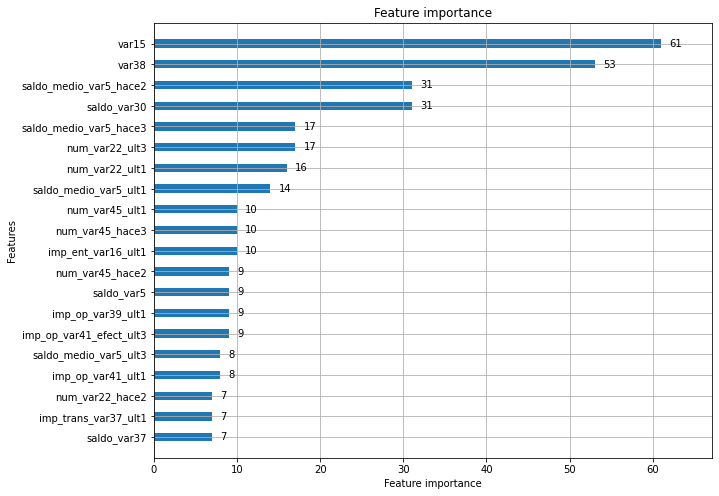

In [28]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1,figsize=(10,8))
plot_importance(lgbm_clf, ax=ax,max_num_features=20,height=0.4 )